
---

## 1. **Chat Messages**

In LangChain/LangGraph, **chat messages** are the building blocks of a conversation. Instead of just plain text prompts, you structure inputs/outputs as **message objects** with roles.

* Types of messages:

  * **SystemMessage** → sets context/behavior (“You are a financial assistant…”).
  * **HumanMessage** → represents user input.
  * **AIMessage** → represents model responses.
  * **ToolMessage / FunctionMessage** → represents calls to tools/functions and their outputs.

Why important in LangGraph:
When you design an agent or chain, you don’t just pass strings — you pass **lists of messages**. This makes conversations stateful, lets you inject tool outputs, and helps maintain multi-turn context.

---

## 2. **Chat Model**

A **Chat Model** is simply a wrapper around an LLM (like OpenAI’s GPT, Anthropic’s Claude, etc.) that understands **chat message objects** instead of raw strings.

* In LangChain:

  ```python
  from langchain_openai import ChatOpenAI
  model = ChatOpenAI(model="gpt-4")
  ```
* It takes `messages=[SystemMessage(...), HumanMessage(...)]` as input and returns `AIMessage`.

Why important in LangGraph:
In a LangGraph chain, the **Chat Model node** is the core “reasoning unit.” It interprets structured messages, decides the next step, and generates output that can either go to the user or trigger a tool.

---

## 3. **Binding Tools**

Binding tools = attaching **functions/APIs** to your chat model so it can call them when needed.

* Tools can be:

  * A database query executor
  * A Python function (e.g., `math`, `search_docs`)
  * External API (weather, finance, etc.)

* In LangChain:

  ```python
  from langchain_core.tools import tool

  @tool
  def add_numbers(a: int, b: int) -> int:
      return a + b

  bound_model = model.bind_tools([add_numbers])
  ```

* The model can now return a `ToolCall` message, which LangGraph recognizes and routes to the correct function.

Why important in LangGraph:
Tools are like **actions your agent can take**. Binding tools is how you give the agent capabilities beyond just text output. Without tool binding, the model is just a chat engine.

---

### Putting it Together in a LangGraph Chain

* **Messages** = structured conversation history.
* **Chat Model** = brain that processes messages and decides next step.
* **Bound Tools** = actions the brain can take inside the graph.

Example flow in LangGraph:

1. User sends a **HumanMessage**: "What’s 5+7?"
2. Chat Model sees it, decides to call tool `add_numbers(5,7)`.
3. LangGraph routes this **ToolCall** to the tool.
4. Tool returns `12` → becomes a **ToolMessage**.
5. Chat Model integrates that result and returns final **AIMessage**: "The answer is 12."



## Chain Using LangGraph

1. How to use Chat messages as our graph state.
2. How to use chat models in graph nodes
3. How to bind tools to our LLM in chat models
4. How to to execute the tools call in our graph nodes.

In [50]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

### How to use Chat messages as our graph state ?

In [51]:
from langchain_core.messages import AIMessage,HumanMessage
from pprint import pprint  # This library is nothing but print the messages in better way.
messages = [AIMessage(content=f"Please tell me how can I help",name="Assistant")]
messages.append(HumanMessage(content=f"I want to learn coding",name="Pawan"))
messages.append(AIMessage(content=f"Which programming Language you want to learn ?",name="Assistant"))
messages.append(HumanMessage(content=f"Hey i want to learn Python with LLM model development, explain me in 10 bullet points and make sure gap is proper between them",name="Pawan"))

for mesage in messages:
    mesage.pretty_print()


================================== Ai Message ==================================
Name: Assistant

Please tell me how can I help
================================ Human Message =================================
Name: Pawan

I want to learn coding
================================== Ai Message ==================================
Name: Assistant

Which programming Language you want to learn ?
================================ Human Message =================================
Name: Pawan

Hey i want to learn Python with LLM model development, explain me in 10 bullet points and make sure gap is proper between them


#### Chat Models

- How to use chat models in graph nodes

In [52]:
# When Chat model called this is how AIMessage model will call and messag is extracted from the model given below.
from langchain_groq import ChatGroq
llm = ChatGroq(model = "qwen/qwen3-32b")
result = llm.invoke(messages)


In [53]:
result.response_metadata

{'token_usage': {'completion_tokens': 723,
  'prompt_tokens': 76,
  'total_tokens': 799,
  'completion_time': 1.529984958,
  'prompt_time': 0.003247848,
  'queue_time': 2.238738405,
  'total_time': 1.533232806},
 'model_name': 'qwen/qwen3-32b',
 'system_fingerprint': 'fp_5cf921caa2',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None}

## Tools

- Tools can be integrated with LLM models to interact with external systems, External systems can be API's , third party tools.
Whenever a query us asked the model can choose to call the tools and this query is based in the natural language input and this will return an output
that matches the tool's schema 

In [54]:
def add(a:int , b:int)->int:
    # Here defining everything in docstring as this help LLM to understand what to do in this.
    """
    Add a and b

    a(int): first int
    b(int): second int

    return:
        int
    """
    return a+b

In [55]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x14fe82fa0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x14fdfd5e0>, model_name='qwen/qwen3-32b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [56]:
## Binding tool with LLM
llm_with_tools=llm.bind_tools([add])
tool_call=llm_with_tools.invoke([HumanMessage(content=f"Hey what answer for 2 plus 3 ?",name="Pawan")])


In [57]:
# To check how tool call responding , we can check from here given below.
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 3},
  'id': 'z0mzd30f8',
  'type': 'tool_call'}]



## 1. **Chat Messages (`AnyMessage`)**

* Messages are the **atoms of conversation**.
* Types: `HumanMessage`, `AIMessage`, `SystemMessage`, `ToolMessage`…
* `AnyMessage` = **union type** → allows a list to store *any* of these messages.
* In the graph state we write:

  ```python
  messages: Annotated[list[AnyMessage], add_messages]
  ```

  This means:

  * `messages` holds a conversation history of mixed roles.
  * Every node that produces messages will **append** them (thanks to `add_messages`) instead of overwriting.

---

## 2. **Chat Model**

* A `ChatModel` (e.g., `ChatOpenAI`) consumes a list of messages and produces an `AIMessage`.
* That `AIMessage` may contain:

  * `content` → plain text
  * `additional_kwargs` → tool/function calls
  * `response_metadata` → token usage, model id, etc.

---

## 3. **Binding Tools**

* We can bind Python functions or APIs as “tools” so the model can call them.
* When bound, the model might return an `AIMessage` with a `tool_call`.
* The graph routes this to the right function, then logs its output as a `ToolMessage`.

---

## 4. **Router**

* Router inspects the **last message**:

  * If it’s a **tool call**, route to tool executor.
  * Otherwise, route to final output.
* This keeps logic clean, instead of writing nested `if/else`.

---

# Example: LangGraph Mini Agent

Here’s a self-contained demo that shows everything:

```python
from typing import Annotated, TypedDict
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage, ToolMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, add_messages, END

# 1. Define State
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

# 2. Define a Tool
@tool
def add_numbers(a: int, b: int) -> int:
    """Add two numbers."""
    return a + b

# 3. Chat Model (with bound tool)
model = ChatOpenAI(model="gpt-4o-mini").bind_tools([add_numbers])

# 4. Router function
def router(state: State):
    last = state["messages"][-1]
    if isinstance(last, AIMessage) and last.additional_kwargs.get("tool_calls"):
        return "tool_executor"
    return "final_output"

# 5. Tool executor node
def tool_executor(state: State):
    last = state["messages"][-1]
    tool_call = last.additional_kwargs["tool_calls"][0]
    fn_name = tool_call["function"]["name"]
    args = eval(tool_call["function"]["arguments"])
    result = add_numbers(**args)  # call the tool
    return {"messages": [ToolMessage(content=str(result), tool_call_id=tool_call["id"])]}

# 6. Final output node
def final_output(state: State):
    last = state["messages"][-1]
    print(" Agent says:", last.content)
    return state

# 7. Build Graph
workflow = StateGraph(State)
workflow.add_node("model", model)
workflow.add_node("tool_executor", tool_executor)
workflow.add_node("final_output", final_output)

workflow.set_entry_point("model")
workflow.add_conditional_edges("model", router, {"tool_executor": "tool_executor", "final_output": "final_output"})
workflow.add_edge("tool_executor", "model")
workflow.add_edge("final_output", END)

app = workflow.compile()

# 8. Run Graph
state = {"messages": [HumanMessage(content="What is 5+7?")]}
final_state = app.invoke(state)

print("\n--- Conversation History ---")
for m in final_state["messages"]:
    print(type(m).__name__, ":", m.content)
```

---

# How This Works

1. **State setup**

   * `messages: Annotated[list[AnyMessage], add_messages]`
   * Ensures conversation history grows properly.

2. **Flow**

   * Human asks: `"What is 5+7?"`
   * Chat model (`AIMessage`) decides to call `add_numbers`.
   * Router detects tool call → sends state to `tool_executor`.
   * Tool executes and returns `ToolMessage("12")`.
   * Model sees tool result, produces final `AIMessage("The answer is 12")`.
   * Router detects no tool call → routes to `final_output`.

3. **History after run**

   ```
   HumanMessage : What is 5+7?
   AIMessage    :   (tool call request)
   ToolMessage  : 12
   AIMessage    : The answer is 12
   ```

---

# Key Takeaway

* **`AnyMessage`**: allows mixed message roles in state. (Human Message and AI message)
* **`add_messages` (reducer)**: appends new messages, keeps history intact.
* **Chat Model**: generates `AIMessage` (may contain tool calls).
* **Router**: decides next step based on the last message.
* **Tools**: extend model capabilities.



In [67]:
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages  # Reducer , it will merge messages and will not allow override messages , allow only append.
from typing import Annotated
from langchain_core.messages import AnyMessage

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]
    

## Reducer with add_messages.

In [68]:
# THis is message feed to LLM model
initial_messages = [AIMessage(content=f"Please tell me how may i help you ", name="Assistant")]
initial_messages.append(HumanMessage(content=f"I want to learn coding",name="Pawan"))
initial_messages

[AIMessage(content='Please tell me how may i help you ', additional_kwargs={}, response_metadata={}, name='Assistant'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Pawan')]

In [69]:
# This is another set of AI message now will feed this to LLM model , by appending this to initial_meassge also this will not override previous message
ai_message=AIMessage(content=f"Which programming language you want to learn",name="Assistant")
ai_message

AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='Assistant')

### Role of Reducer , to append instead of override

In [70]:
# Here i added initial_messages with ai_message and here we can see initial and AI message is combined together
add_messages(initial_messages,ai_message)

[AIMessage(content='Please tell me how may i help you ', additional_kwargs={}, response_metadata={}, name='Assistant', id='5946bffc-2b1f-416c-a5b4-b710465665b5'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Pawan', id='fbc86e05-278d-4bd8-9a09-54ff89e99a29'),
 AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='Assistant', id='cd249376-b01b-4a46-81d7-70489fc8000e')]

In [71]:
# Chatbot node functionality 
def llm_tool(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [72]:
from IPython.display import Image , display
from langgraph.graph import StateGraph , START,END
builder = StateGraph(State)

builder.add_node("llm_tool",llm_tool)
builder.add_edge(START,"llm_tool")
builder.add_edge("llm_tool",END)

In [73]:
graph = builder.compile()

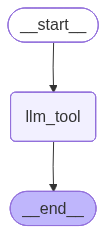

In [74]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [76]:
# Invocation

messages = graph.invoke({"messages":"What is 2 plus 7"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 7
================================== Ai Message ==================================
Tool Calls:
  add (j2mhma3qs)
 Call ID: j2mhma3qs
  Args:
    a: 2
    b: 7
